# k-Nearest Neighbor

-----

In this notebook, we introduce one of the simplest machine learning algorithms, [**k-nearest neighbors**][wknn] (k-nn), and demonstrate how to effectively use this algorithm to perform both classification and regression. This algorithm works by finding the $k$ nearest neighbors to a new instance, and using the features of these neighbors to predict the feature for the new instance. If the feature is discrete, such as a class label, the prediction is classification, while if the feature is continuous, such as a numerical value, the prediction is regression.

The k-nn algorithm is different than most other algorithms in several ways. First, the algorithm is a lazy learner in that no model is constructed. Instead, the predictions are made straight from the training data. Thus, the `fit` method in the relevant scikit-learn [k-nn estimator][sknn] doesn't build a model, it instead builds an efficient representation of the training data. Second, this algorithm is non-linear and non-parametric since no model is constructed.

To understand why this algorithm works, simply look at society in general. You likely live near people who are similar to you in income, educational level, and religious or political beliefs. These inherent relationships are often captured in data sets, and can thus be used by neighbor algorithms to make reasonable predictions. At its simplest, one neighbor is used, and the feature from this neighbor is used to make the prediction. As more neighbors are added, however, a descriptive statistic can be applied to the nearest neighbor features. Often this is the mode for a discrete prediction or the mean value for a continuous prediction, but other statistics can also be used. In addition, we can weight the statistic to account for the proximity of different neighbors. Thus, we may use a weighted mean for a regression prediction.

This notebook first introduces the underlying formalism of the k-nn algorithm, which includes a discussion of distance metrics and the _curse of dimensionality_ before loading the Iris data that we will often use to introduce a new machine learning algorithm. New to this notebook, we begin to use _helper code_ that is contained in a separate file and imported into this Notebook to keep this notebook clean and focused on the task at hand. You can, of course, load this file from the notebook server to view the functions. In this case, the code was previously presented in the Introduction to Machine Learning notebook.

Next, we will demonstrate the k-nn algorithm by classifying the Iris data, including how to quantify the performance of the algorithm by using a confusion matrix and several standard performance metrics. Next, we look at how the k-nn hyperparameters affect the classifications results, which will be done by introducing the _decision surface_. Finally, we will demonstrate the k-nn algorithm by regressing a sampled function.

-----
[wknn]: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
[sknn]: http://scikit-learn.org/stable/modules/neighbors.html

## Table of Contents

[Formalism](#Formalism)

- [Curse of Dimensionality](#Curse-of-Dimensionality)

- [Distance Measures](#Distance-Measures)

[Iris Data \[Helper Code\]](#Iris-Data-[Helper-Code])

[k-Nearest Neighbors: Classification](#k-Nearest-Neighbors:-Classification)

- [Performance Metrics](#Performance-Metrics)

- [k-Nearest Neighbors: Hyperparameters](#k-Nearest-Neighbors:-Hyperparameters)
    - [Neighbors](#Neighbors)
    - [Weights](#Weights)

[k-Nearest Neighbors: Regression](#k-Nearest-Neighbors:-Regression)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

Fundamentally, this algorithm is remarkably simple and is based on the principle that data values in an $N$- dimensional space are generally located near other similar objects. The number of nearest neighbors, `k`, is a tuning parameter, and can be specified a priori, or in some algorithms empirically determined. The basic principle behind k-nn is demonstrated in the figure generated by the following code cell. This code cell generates random data (excluding a circle near the sample point for clarity), and uses the scikit-learn [`NearestNeighbors`][sknn] estimator to find the $k$ nearest neighbors. We use this information to construct arrows in the plot between our sample point of interest and the nearest neighbors.

Several points in the following code cell deserve additional comment. First, note how we specify the random state. This ensures that subsequent calls to this code cell will generate the same random sequence, thus the code will be reproducible. Second, we first sample our data in polar coordinates ($r$, $\theta$) and subsequently transform to Cartesian coordinates ($x$, $y$). This demonstrates how it is often easier to rethink a problem in order to find a simpler solution (in this case we want an excluded zone to place our sample point for clarity in the plot). 

Finally, we need to call `reshape` and `flatten` on our NumPy arrays in order to transform the arrays into the appropriate shape expected by the scikit-learn or matplotlib functions respectively. The `reshape` method creates a two-dimensional matrix of our coordinate vectors, while the `flatten` method converts the data from a two-dimensional matrix to a one-dimensional vector. 

-----

[sknn]: http://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors

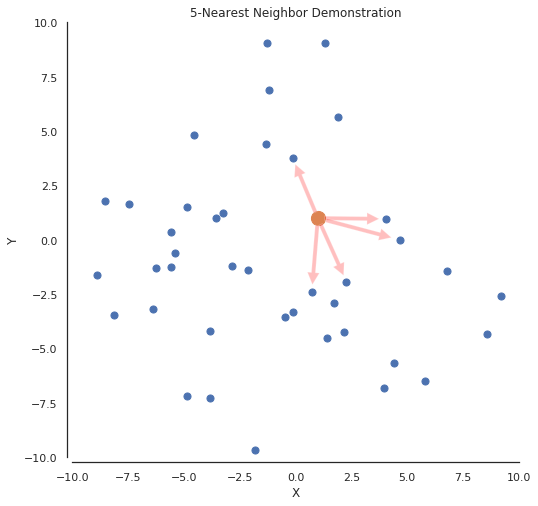

In [2]:
from matplotlib import cm
from sklearn.neighbors import NearestNeighbors

# Parameters for demonstration
num_pts = 40
num_nbrs = 5

sample_point = np.array([1, 1])

# Set random state for reproducability
rng = np.random.RandomState(23)

# Random radial and theta data in ring
radius = rng.uniform(2.5, 10.0, num_pts)
theta = rng.uniform(0, 360, num_pts)

# Transform to Cartesian
x = radius * np.sin(theta)
y = radius * np.cos(theta)

# Stack data into two-dimensional array
data = np.hstack((x.reshape(num_pts, 1), y.reshape(num_pts, 1)))

# Create nearest neighbors estimator
nbrs = NearestNeighbors(n_neighbors=num_nbrs).fit(data)

# Compute distances and indices of nearest neighbors
distances, indices = nbrs.kneighbors(sample_point.reshape(1, -1))

# Flatten the matrices to vectors
distances = distances.flatten()
indices = indices.flatten()

# Set up plot area
sns.set(style="white")
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data and sample point
ax.scatter(x, y, s=50, cmap=cm.coolwarm)
ax.scatter(sample_point[0], sample_point[1], s=200, cmap=cm.coolwarm)

# Loop over neighbors
for idx in range(num_nbrs): 
    # Draw an arrow between sample point and neighbor
    ax.annotate('', xytext=sample_point, xy=data[indices[idx]],
                arrowprops=dict(facecolor='red', alpha=0.25, shrink=0.1))

# Decorate plot
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set(xlabel = 'X', ylabel='Y', title=f'{num_nbrs}-Nearest Neighbor Demonstration')
sns.despine(offset=5, trim=True)

-----

As shown in the previous plot, when a new datum is added (e.g., the large green point), the k-nn algorithm first identifies the $k$ nearest neighbors (in the example above this is five by default, shown by the red arrows to the nearest five blue points). Given these nearest neighbors, a statistical evaluation of their relevant feature is performed, and the result used to make the prediction for the new data point. The statistical evaluation can be simple, such as choosing the mode from a set of discrete classes, or more complex, such as choosing the weighted mean of the features from the nearest neighbors, where the weight might be determined by the relative distance of each neighbor from the datum of interest.

Fundamental to this algorithm is the concept of **distance**. To this point we have simply assumed the features used to define _neighbors_ followed a standard Euclidean distance (i.e., normal spatial coordinates). While this is often the case, some problems require a different distance. The next subsection explores this concept in more detail.

-----

[[Back to TOC]](#Table-of-Contents)

### Distance Measurements

To determine neighbors, we must adopt a definition for the distance. Naively, we might think this is simple, we adopt the common concept of distance that underlies the Pythagorean theorem: $d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$ where $d$ is the distance between two-dimensional points $(x_1, y_1)$ and $(x_2, y_2)$. However, this is really only true for data that follow a [Euclidean distance][wed] metric, such as points on a cartesian plot. This is not true for calculating other distances, even spatial ones, such as the distance a plane flies on a long-distance flight. Furthermore, many data likely require an alternative definition of distance. For example, currency data, categorical data, or text data all likely require different definitions for distance.

Formally, a [_metric_][wm] defines how distances are measured for a particular set of data. The scikit-learn library supports different [distance metrics][skdm] in the `neighbors` module. Some of the standard metrics in this module include:

- [`euclidean`][wed]: supports the standard concept of spatial distance, and is the `l2-norm`.
- [`manhattan`][wmd]: restricts distance measurements to follow grid lines. This metric is sometimes referred to as the Taxi cab distance, since taxis must follow streets, which also gives rise to its formal name, _manhattan_, for the street grid on the island of Manhattan. This distance is also known as the `l1-norm`.
- [`haversine`][whd]: calculates the distance travelled over the surface of a sphere, such as the Earth.
- [`chebyshev`][wcd]: assumes the distance is equal to the greatest distance along the individual dimensions.
- [`minkowski`][wmd]: a generalization of the Manhattan and Euclidean distances to arbitrary powers.

These different metrics (except for the haversine distance metric) are demonstrated in the following code cell. First, we create the appropriate distance metric, and next use the metric to compute pairwise distances. In this simple example, we only have two points, so the computation generates a single distance for each metric. The results are as expected, the Euclidean distance is given by the `l2-norm` (i.e., the Pythagorean theorem), the Manhattan distance is given by the `l1-norm`, the Chebyshev distance is simply one, and the Minkowski distance equals the Manhattan and Euclidean distances when the power is one and two, respectively, but generalizes to higher powers.

-----
[wm]: https://en.wikipedia.org/wiki/Metric_(mathematics)

[skdm]: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
[wed]: https://en.wikipedia.org/wiki/Euclidean_distance
[wcd]: https://en.wikipedia.org/wiki/Chebyshev_distance
[wmd]: https://en.wikipedia.org/wiki/Taxicab_geometry
[whd]: https://en.wikipedia.org/wiki/Haversine_formula
[wmd]: https://en.wikipedia.org/wiki/Minkowski_distance

In [3]:
from sklearn import neighbors

# Create two sample points as two-dimensional matrices
p1 = np.array([0, 1, 2]).reshape(1, 3)
p2 = np.array([1, 2, 3]).reshape(1, 3)

# Create distance metrics
eud = neighbors.DistanceMetric.get_metric('euclidean')
mad = neighbors.DistanceMetric.get_metric('manhattan')
chd = neighbors.DistanceMetric.get_metric('chebyshev')

# Compute and display different distances
print('Eucliden distance: {:5.3f}'.format(eud.pairwise(p1, p2)[0][0]))
print('Manhattan distance: {:5.3f}'.format(mad.pairwise(p1, p2)[0][0]))
print('Chebyshev distance: {:5.3f}\n'.format(chd.pairwise(p1, p2)[0][0]))

# Compute and display generic metric distance
for idx in range(1, 6):
    arg = dict(p=idx)
    
    mid = neighbors.DistanceMetric.get_metric('minkowski', **arg)
    dst = mid.pairwise(p1, p2)[0][0]
    print(f'Minkowski (p = {idx}) distance: {dst:5.3f}')

Eucliden distance: 1.732
Manhattan distance: 3.000
Chebyshev distance: 1.000

Minkowski (p = 1) distance: 3.000
Minkowski (p = 2) distance: 1.732
Minkowski (p = 3) distance: 1.442
Minkowski (p = 4) distance: 1.316
Minkowski (p = 5) distance: 1.246


-----

[[Back to TOC]](#Table-of-Contents)

### Curse of Dimensionality

In general, we strive to obtain as much data as possible to improve our model prediction. The additional data can take one of two forms: additional features, which increases the dimensionality of our data set, or additional instances, which increases the pool of data from which to draw training and testing samples. Additional instances impacts a machine learning process in a simple manner, more data requires more computational power for either storing the data, or to process the data more rapidly. Additional dimensions on the other hand, can introduce an additional complication that is known as the [_curse of dimensionality_][wcd].

At its simplest, the curse of dimensionality relates the density of training data to the performance of our machine learning algorithm. In order to ensure sufficient density of training data across a potential sample space, the quantity of training data must increase exponentially (or very rapidly) with each new dimension. Otherwise, we end up with a space that is poorly sampled by training data. This issue is demonstrated in the following code cell, where we compute the number of training data that are required to maintain a fixed density of training points (e.g., set to five in the example). As shown in the code output, the number of training data increases exponentially. Effectively, if our sampling density is $d$, we must acquire a factor of $d$ more data with every additional dimension in order to maintain the same sampling frequency.

-----

[wcd]: https://en.wikipedia.org/wiki/Curse_of_dimensionality



In [4]:
# Display number of data points required to maintain constant density

# Target density
density = 5

# Dimensions
dims = np.linspace(1, 10, 10)

# Required number of points
num_pts = (np.power(density, dims))

# Display results
print('Dimension  Number of Points')
print(27*'-')
for d, n in zip(dims, num_pts):
    print(f'{int(d):9d}  {int(n):16d}')

Dimension  Number of Points
---------------------------
        1                 5
        2                25
        3               125
        4               625
        5              3125
        6             15625
        7             78125
        8            390625
        9           1953125
       10           9765625


-----

An alternative way to view this issue is to visualize how the relative density changes as new dimensions are added when we keep the same number of training data. The following code cell displays how the relative density changes with increasing dimension. Note that for this example, we fix the density to be one for a three-dimensional volume enclosed by the unit sphere.

-----

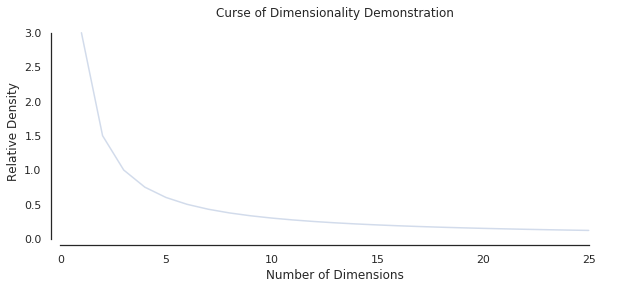

In [5]:
# Number of sample points
num_pts = 1000

# Dimensions
dims = np.linspace(1, 25, 25)

# Relative density for specific dimension
density = np.log10(np.power(num_pts, 1./dims))

# Set up plot area
sns.set(style="white")
fig, ax = plt.subplots(figsize=(10, 4))

# Plot data and sample point
ax.plot(dims, density, c='b', alpha=0.25)

# Decorate plot
ax.set(xlabel='Number of Dimensions', 
       ylabel='Relative Density', 
       title='Curse of Dimensionality Demonstration')

sns.despine(offset=5, trim=True)

-----

Note that some algorithms are affected more strongly by the curse of dimensionality, especially techniques that rely on distance measurements. Thus, the k-nn algorithm can be strongly affected by this issue, which can be visualized by looking closely at the decision surfaces. To overcome the curse of dimensionality, one must either increase the amount of training data, or reduce the dimensionality by either identifying the most important features or deriving new features that contain most of the information. Both of these topics, which fall under the category of **feature engineering** will be addressed in later notebooks.

----

[[Back to TOC]](#Table-of-Contents)

## Iris Data [Helper Code]

In this course, we will use the standard Iris classification data set to explore how to perform basic classification tasks, starting in this notebook with the k-nearest neighbors, or k-nn, algorithm. The four primary dimensions of the data include Sepal Length, Sepal Width, Petal Length, and Petal Width. The data set consists of 150 total measurements of three different types of Iris flowers, equally divided between three classes: Iris setosa, Iris versicolor, and Iris virginica. 

To simplify the code in this notebook, we will use custom _helper code_. This code first appeared in the Introduction to Machine Learning notebook, but has now been saved in the file _iris.py_ in the _helper\_code_ subdirectory. This allows us to import this code as a Python module into the current notebook. This file defines four functions
- `get_iris_data`: loads the Iris data, returns the data split into training and testing sets, and optionally creates a two-dimensional scatter plot of the data.
- `get_mdata`: creates and returns a two-dimensional meshgrid spanned by the training data.
- `trim_data`: trims the full Iris data to only the contain the sepal width and petal width features.
- `splot_data`: plots the data and meshgrid as a decision surface. This shows how the algorithm classified both the data and the space spanned by the data, which can help in understanding how the performance of a classifier varies as the hyperparameters change.

We demonstrate this _helper code_ in the following code cells, by first importing the module and loading and plotting the data.

-----

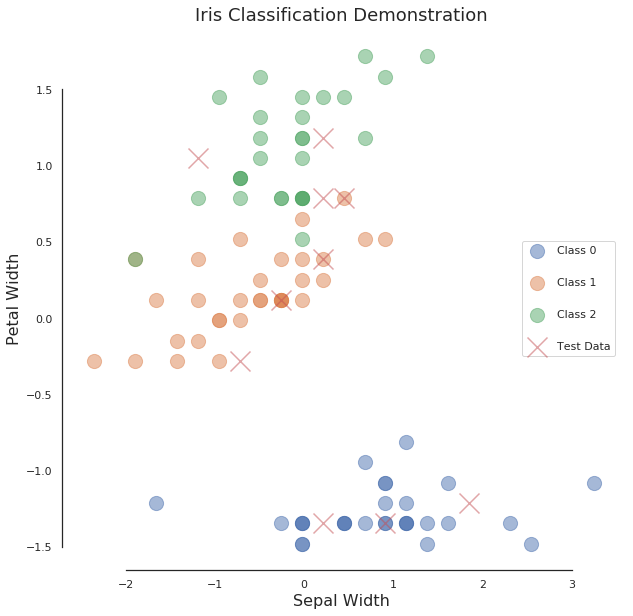

In [6]:
from helper_code import iris as hi

# Amount to hold out for 'blind' testing
test_frac = 0.4

# Show the 'Train' and 'Test' data plot.
show_plot = True

# Split data into training and testing
# Note that we have both 'data' and 'labels'
d_train_sc, d_test_sc, l_train, l_test = hi.get_iris_data(test_frac, show_plot)

-----

[[Back to TOC]](#Table-of-Contents)

## k-Nearest Neighbors: Classification

We can now apply the k-nn algorithm to the Iris data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Import the proper module, `neighbors`.
2. Create the estimator, [`KNeighborsClassifier`][skknc] and specify hyperparameters. In this case we need to specify the number of neighbors, but we can use the default weight, which is `uniform`.
3. Fit the model to the training data, note that by using our simple `get_iris_data` helper function we have loaded the Iris data, split the data into training and testing sets, and scaled all data by first normalizing the training data.
4. Predict new classes with our trained model (or in the simple demonstration below, generate a performance metric via the `score` method).

These steps are demonstrated in the following code cell, where we create our estimator, fit the estimator to our training data, and generate a performance score on the testing data. Note that by default, the classification from the features of multiple neighbors is done by a simple majority vote (which is equivalent to the mode of the discrete labels). Finally, if multiple neighbors are at the same distance but have different labels, the ordering of the trading data will impact which label is used in the voting process.

-----
[skknc]: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification

In [7]:
# The number of neighbors affects performance
nbrs = 5

# First we construct our model
knc = neighbors.KNeighborsClassifier(n_neighbors=nbrs)

# Now train our model
knc.fit(d_train_sc, l_train)

# Compute and display accuracy score
score = 100.0 * knc.score(d_test_sc, l_test)
print(f"KNN ({nbrs} neighbors) prediction accuracy = {score:5.1f}%")

KNN (5 neighbors) prediction accuracy =  96.7%


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we generated a classification model for the Iris data. Modify the previous code cells to make the following changes, and comment on how the performance of the classifier changes.


1. Change the cross-validation split size, for example change from a 75%:25% to a 50%:50%?
2. Change the number of neighbors to 1, 5, and 10.
3. Try changing the data in the previous plot to show different axes. You can either edit the helper code in the iris.py file, or change the order of columns (or features) in the current data array. How does this new visualization compare to the original version?



-----

[[Back to TOC]](#Table-of-Contents)

### Performance Metrics

As previously demonstrated, we can call the `score` method on our k-nn classifier to compute and display a simple performance metric (or value). In general, however, there are a number of different metrics that can be used to quantify the performance of a classification algorithm, and the scikit-learn library provides support to compute many of these metrics in the `metrics` module. 

In our Iris data classification example, we are performing a multiple classification task where we have more than two labels. As a result, one of the simplest ways to understand our performance is to create and display a [_confusion matrix_][wcd]. A confusion matrix has rows that correspond to the true labels and columns that correspond to the predicted labels. The elements of the confusion matrix contain the number of instances with true label given by the row index and the predicted label by the column index. A perfect classification, therefore, would have a confusion matrix populated entirely along the diagonal.

We can compute a confusion matrix by calling the `confusion_matrix` method in the `metrics` module. This is demonstrated in the following code cell, where this matrix is calculated and the results displayed. In this simple 3 x 3 matrix, the results can be viewed and understood, but visualizing the matrix can be more intuitive. Thus, the second code cell defines a new helper function that plots a confusion matrix for these data. Both the color of the cells in this heatmap visualization and the numbers displayed in each cell convey the classification accuracy. In this case, we see that the classifier only misclassifies two instances of Iris virginica as Iris versicolor. This type of visualization is a powerful technique to convey the performance of a machine classification.

-----

[wcd]: https://en.wikipedia.org/wiki/Confusion_matrix

In [8]:
from sklearn.metrics import confusion_matrix

# Generate predictions
l_pred = knc.predict(d_test_sc)

# Create and display confusion matrix
print(confusion_matrix(l_test, l_pred))

[[21  0  0]
 [ 0 18  0]
 [ 0  2 19]]


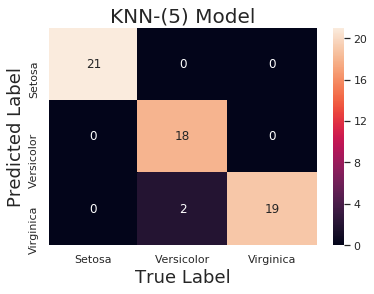

In [9]:
# Convenience function to plot confusion matrix

# This method produces a colored heatmap that displays the relationship
# between predicted and actual types from a machine learning method.

def confusion(test, predict, title):
    # Define names for the three Iris types
    names = ['Setosa', 'Versicolor', 'Virginica']

    # Make a 2D histogram from the test and result arrays
    # pts is essentially the output of the scikit-learn
    # confusion_matrix mathod
    pts, xe, ye = np.histogram2d(test, predict, bins=3)

    # For simplicity we create a new DataFrame for the confusion matrix
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    
    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title(title, fontsize=20)
    hm.axes.set_xlabel('True Label', fontsize=18)
    hm.axes.set_ylabel('Predicted Label', fontsize=18)

    return None

# Call confusion matrix plotting routine
confusion(l_test, l_pred, f'KNN-({nbrs}) Model')

----

While the confusion matrix provides a useful visualization of the performance of a classification, in some cases a numerical score is desired. A number of different scores have been proposed for classification tasks, which one is most useful often depends on the nature of the classification task. Two commonly used scores are the [_precision_ and the _recall_][wpr]. Note that both of these scores are ratios, and thus take values between zero (bad) and one (good).

Simply put, the precision (sometimes called the positive predictive value) is a measure of how many instances were correctly classified with the appropriate label. Thus, the precision is computed as the ratio of the number of instances correctly classified with a given label to the number of instances that actually have that label. Recall (sometimes called sensitivity) measures how many of the instances that were classified with a given label actually have that label. Thus, recall is computed as the ratio of correctly classified instances of a given label to the number of instances classified with that label.

Thus, from our confusion matrix above, we can see that Iris setosa has a precision of 1.0 and a recall of 1.0, as all instances are correctly classified. On the other hand, Iris versicolor has a precision of $0.9 (\approx 18/20$) and a recall of 1.0 since two Iris virginica were misclassified as Iris versicolor. These two scores are flipped for Iris virginica, which had two flowers incorrectly classified as Iris versicolor, so recall is equal to $0.9 (\approx 19/21$).

To generate one single numerical score, the [_f1-score_][wf1] was created, which is simply the harmonic mean of the precision and the recall (note, we must use the harmonic mean since these scores are actually ratios). Finally, one additional value of interest when interpreting these results is the _support_, which is the number of instances of each label in the testing set that was used to compute the indicated score. In our example, we held 40% of the data out for testing, which implies that $0.4 \times 150 = 60$ instances will be held out for testing. A uniform sampling would mean around twenty of each type of Iris. 

While the scikit-learn library has functions to compute each of these metrics (e.g., `precision_score` for the precision), we can compute and display these performance metrics by using the [`classification_report`][skcr] function in the `metrics` module. The following code cell demonstrates this for our Iris classification task. In this case, we see that the result matches our expectations computed from the confusion matrix, and that our support is nearly uniform. These and other performance metrics will be discussed and demonstrated more thoroughly in later notebooks.

In the following code example, we also pass in a list of target names. If we didn't do this, the labels would simply be listed as Class 0, Class 1, and Class 2. In addition, the number of floating point digits (or the number of digits displayed past the decimal point) can be controlled by the `digit` parameter. Passing a large value, such as `4`, will distinguish between the Iris versicolor precision and Iris virginica recall.

-----

[wpr]: https://en.wikipedia.org/wiki/Precision_and_recall
[wf1]: https://en.wikipedia.org/wiki/F1_score
[skcr]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [10]:
from sklearn.metrics import classification_report

# Compute and display classification report
print(classification_report(l_test, l_pred, \
                            target_names = ['Setosa', 'Versicolor', 'Virginica']))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        21
  Versicolor       0.90      1.00      0.95        18
   Virginica       1.00      0.90      0.95        21

   micro avg       0.97      0.97      0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



-----

[[Back to TOC]](#Table-of-Contents)

### k-Nearest Neighbors: Hyperparameters

Machine learning algorithms often have tuning parameters that are extrinsic to the algorithm that cannot be determined directly from the data being analyzed. These parameters are formally known as hyperparameters. The k-nn algorithm has two hyperparameters: the number of nearest neighbors and a weighting scheme. To demonstrate how these hyperparameters affect the performance of the k-nn algorithm the following two subsections create a k-nn estimator with different values for these hyperparameters and display the results. To more effectively visualize the impact of these hyperparameters, we introduce the **decision surface**. 

A decision surface is a visualization that shows a particular space occupied by the training data, in this case just the two dimensions: Sepal Width and Petal Width. The training data, color coded by their class, are displayed on this plot. In addition, the entire space spanned by the plot has been divided into a mesh grid, and each point in the mesh grid has been classified by the algorithm being analyzed. This has the effect of showing how new test data points would be classified as they move around the plot region. By comparing decision surfaces that correspond to different hyperparameter values, we can understand the corresponding change in the algorithm's performance.

----

#### Neighbors

The first hyperparameter we will vary is the number of neighbors. The following code cell creates different k-nn classification estimators for three different values of the number of neighbors (in the example this is 2, 3, and 5). As the number of neighbors increases, we tend to average over the distribution of training data, which makes the decision surface  cleaner with smaller variations. Depending on the data being analyzed, this can be either a good or bad result. As the example below demonstrates, increasing the number of neighbors does not have a strong effect on the classification performance, likely due to the small size of our data. One additional point to remember, as the plots below show, we have scaled our data, thus the plot region does not correspond to the original ranges spanned by these data.


-----

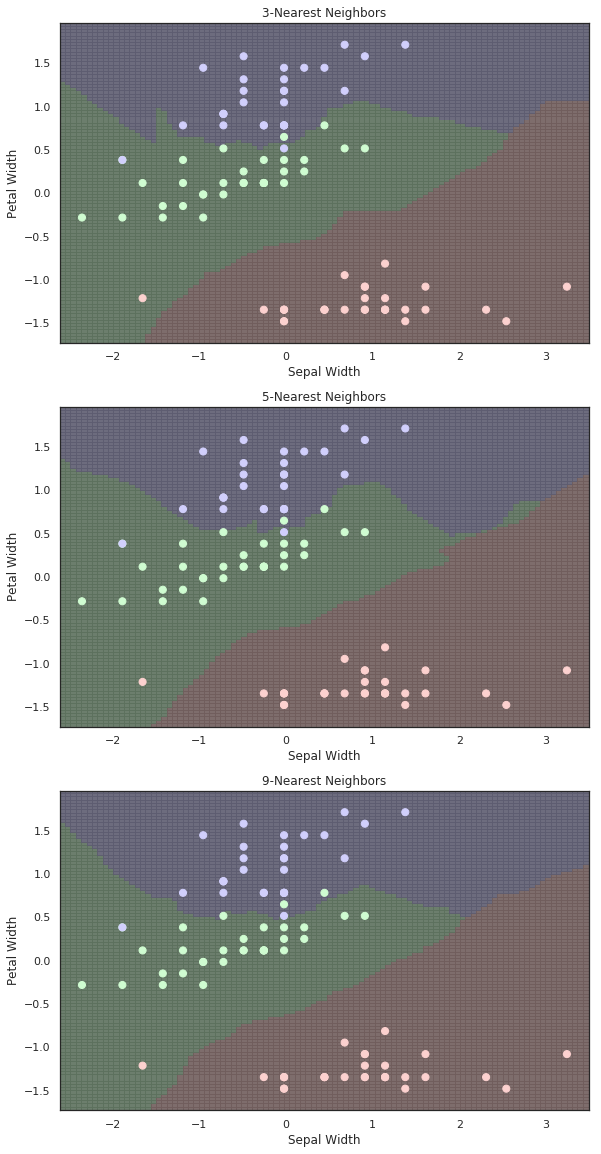

In [11]:
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

# Show the mesh grid and training data

sns.set(style="white")
fig, axs = plt.subplots(figsize=(10,20), nrows=3, ncols=1, 
                        sharex=False)

# Iterate through different neighbor counts
for idx, nbrs in enumerate([3, 5, 9]):
    
    # Now train our model
    knc.set_params(n_neighbors=nbrs)
    
    # Now train our model
    knc.fit(n_data[:,:2], n_data[:,2])
    
    # Predict for mesh grid
    z = knc.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'{nbrs}-Nearest Neighbors')

-----

#### Weights

The second hyperparameter that can be specified in the k-nn algorithm is the _weight_ used to compute the statistical summary of the neighbor features. The scikit-learn neighbors module supports three different values for the weight hyperparameter. By default, `uniform` weighting is used, which means each neighbor is treated equally. The other simple choice for the weight hyperparameter is to use `distance` weighting, where the features from different neighbors are weighted by the inverse of their distance. Thus, closer points are weighted more than distant neighbors. Finally, the third option for this hyperparameter is to provide a user-defined function that accepts an array of distances and returns the appropriate weights. This last option enables an analyst to leverage one of the other distance metrics discussed previously in this notebook that are supplied by the neighbors module.

The following code cell contrasts the effects of changing the weight hyperparameter on our Iris data classification. This is done by classifying the data with both the `uniform` and `distance` weights, and displaying the resulting decision surface for the same value of the number of nearest neighbors hyperparameter. As shown below, the `distance` weight generates a more varied decision surface that better captures the distribution of training data. While this may often be the case, a proper evaluation with more data and the use of performance metrics, such as those discussed previously, should be used for the optimal selection of all hyperparameters.

-----

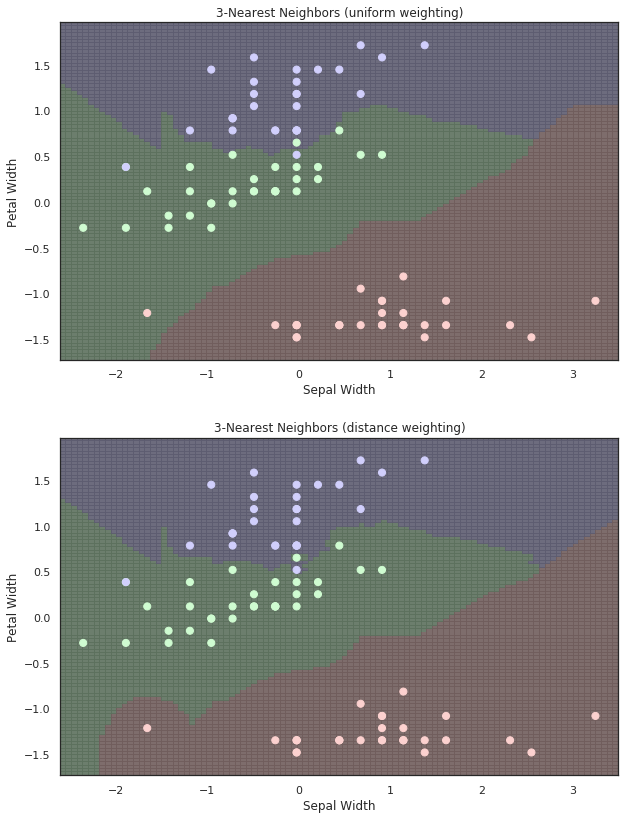

In [12]:
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

# Show the mesh grid and training data

sns.set(style="white")
fig, axs = plt.subplots(figsize=(10,14), nrows=2, ncols=1, 
                        sharex=False)
nbrs = 3

# Iterate through different neighbor counts
for idx, weights in enumerate(['uniform', 'distance']):
    knc.set_params(n_neighbors=nbrs, weights=weights)
    
    # Now train our model
    knc.fit(n_data[:,:2], n_data[:,2])
    
    # Predict for mesh grid
    z = knc.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'{nbrs}-Nearest Neighbors ({weights} weighting)')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we changed the hyperparameters for our k-nn classification on the Iris data. Modify the previous code cells to make the following changes and comment on how the performance of the classifier changes.

1. Change the test:train split value to provide more and less training data. How does the decision surface change?
3. Change the number of neighbors along with the weighting scheme. Can you find an optimal set of hyperparameters for a given test:train split?
3. How do the performance metrics change as the hyperparameters change? Try using the classification_report function to display the performance metrics for different hyperparameter combinations.

-----

[[Back to TOC]](#Table-of-Contents)

## k-Nearest Neighbors: Regression

As is the case with many of the supervised learning algorithms implemented in the scikit-learn library, the k-nn algorithm can be used for classification (as demonstrated previously) and for regression. To generate a regression model by using the k-nn algorithm we must create a [`KNeighborsRegressor`][skkr] estimator, which simply predicts a continuous value by taking the mean of the continuous labels from the nearest neighbors. Thus, while simple, this approach is often not optimal unless a large number of neighbors with many features are used.

K-nearest neighbor regression is demonstrated in the following two code cells. First, we create random data consisting of a _cosine_ with additional random perturbations. This demonstration is an adaption of the [example provided][skke] by the scikit-learn library. First, we set our random state to enable reproducibility, before generating random values for our independent and dependent variables.

In the second code cell, we compute our k-nearest neighbor regression by using five neighbors, but with two different weighting schemes: `uniform` and `distance`. The results are plotted showing the original curve and the model fits at the sample points (`xx`). In this example, the benefit of using the `distance` weighting scheme is obvious, since this generates a weighted mean for the predicted value.

-----

[skkr]: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression
[skke]: http://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html

In [13]:
# Modified example at scikit learn:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html

# Make the data
rns = np.random.RandomState(23)

# Maximum range in x
xhigh = 25

# Number of points for model
num_pts = 40

# Generate random data and convert to an ordered list by sorting
x = np.sort(xhigh * rns.rand(num_pts, 1), axis=0)

# Generate dependent variable as the cosine plus noise.
y = np.cos(x) + (0.5 - rns.rand(num_pts, 1))

# Generate uniform sampling points.
xx = np.linspace(0, xhigh, num_pts * 5)[:, np.newaxis]

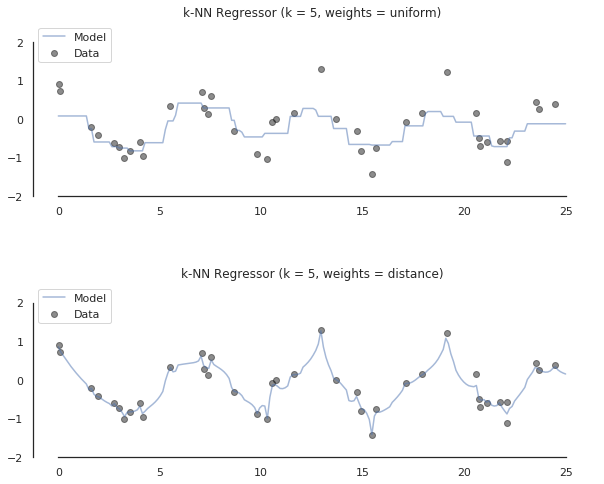

In [14]:
# Make the plots
fig, axs = plt.subplots(figsize=(10, 8.0), nrows=2, ncols=1, sharex=False)
adj = plt.subplots_adjust(hspace=0.5)

# Define k
n_neighbors = 5

# Iterate over two wegith schemes
for idx, weights in enumerate(['uniform', 'distance']):

    # Create Regressor, fit to training data, predict for new data
    knr = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knr.fit(x, y).predict(xx)
    
    # Plot data and model
    axs[idx].scatter(x, y, c='k', alpha = 0.5, label='Data')
    axs[idx].plot(xx, y_, c='b',  alpha = 0.5, label='Model')
    
    # Decorate plot appropriately
    ttl = f'k-NN Regressor (k = {n_neighbors}, weights = {weights})'
    axs[idx].set_title(ttl)
    axs[idx].set_ylim(-2, 2.5)
    axs[idx].legend(loc=2)
    sns.despine(ax=axs[idx], trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used k-nn regression on randomly generated data. Modify the previous code cell to make the following changes and comment on how the performance of the regressor changes.

1. Change the random state value to see how the data and model change.
3. Change the sampling frequency (`num_pts`) higher and lower in order to see how the quality of the regression changes. Do the different weights still affect the performance for higher `num_pts`?
3. Change the model from `np.cos` to a different function (try other NumPy functions, or combinations of other functions). Does the performance of the regression model change?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. An article by Saravanan Thirumuruganathan detailing the [k-nn algorithm][1]
1. An article by Manu Jeevan on [k-nn and the curse of dimensionality][2]
2. Scikit Learn information on [Distance Metrics][3], which are used in the neighbor algorithms
56. An article by Yohan Obadia that discusses the use of the [k-nn algorithm for imputation][4] of missing values, note that different distance metrics are also discussed in this article.

-----

[1]: https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/
[2]: http://bigdata-madesimple.com/k-nearest-neighbors-curse-dimensionality-python-scikit-learn/
[3]: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
[4]: https://medium.com/towards-data-science/the-use-of-knn-for-missing-values-cf33d935c637

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 